In [1]:
%matplotlib inline
%pdb on

from pprint import pprint
from metrics import wer, cew, ssr, average, hreff
import montecarlo
import dms
import withdrawal
import mortality
from portfolio import Portfolio
from harvesting import make_rebalancer, PrimeHarvesting
from decimal import Decimal as D

import plot
from matplotlib import pyplot as plt

import pandas

Automatic pdb calling has been turned ON


In [2]:
survival_function = mortality.make_mortality(mortality.ANNUITY_2000)

In [3]:
HREFF_FLOOR = 3

def run_one(basecase, factory):
    # The montecarlo used above has the stock/bond split baked in
    # So we pretend we have a 100% stock portfolio in order to handle
    # harvesting of cash
    p = Portfolio(600000, 400000)
    h = make_rebalancer(.6)(p).harvest()
    #h = PrimeHarvesting(p).harvest()
    h.send(None)
    w = factory(p, h).withdrawals()

    cashflows = []
    returns = []
    
    # the previous year's returns
    x = None

    for i in range(mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_function)):
        # Withdrawals happen at the start of the year
        # So we first withdraw cash.
        cashflows.append(w.send(x).withdraw_pct_orig)
        
        # Then the year happens and we store the returns
        x = basecase.random_year()
        returns.append(x.stocks)

    w = wer(cashflows, returns)
    h = hreff(cashflows, returns, floor=D(HREFF_FLOOR)/100)
    return (w, h)

In [4]:
def calc(factory):
    runs = 1000
    dataset = montecarlo.historical[60]
    wers = []
    for i in range(runs):
        wers.append(run_one(dataset, factory))
    wer = average([w[0] for w in wers])
    hreff = average([w[1] for w in wers])
    return (wer, hreff)

In [5]:
results = {}

In [6]:
results['gummy Sensible'] = calc(withdrawal.SensibleWithdrawals)

In [7]:
results['Bengen Floor-to-Ceiling'] = calc(withdrawal.FloorCeiling)

In [8]:
results['Guyton-Klinger Decision Rules'] = calc(withdrawal.Guyton)

In [9]:
#results['Clyatt 95%'] = calc(withdrawal.Clyatt)

In [10]:
#results['Vanguard'] = calc(withdrawal.Vanguard)

In [11]:
#results['Walton Tilt 1/3'] = calc(withdrawal.TiltCapital)

In [12]:
results['IRS RMD'] = calc(withdrawal.IRS_RMD)

In [13]:
#results['Ingliss Feel Free'] = calc(withdrawal.FeelFree)

In [14]:
#results['Siegel & Waring ARVA'] = calc(lambda p, h: withdrawal.ARVA(p, h, discount_rate=D('.02')))

In [15]:
results['longinvest VPW'] = calc(lambda p, h: withdrawal.VPW(p, h, replan=True))

In [16]:
#results['Walton Inverted'] = calc(withdrawal.InvertedWithdrawals)

In [17]:
#results['Blanchett Simple Formula'] = calc(withdrawal.SimpleFormula)

In [18]:
#results['Pye Retrenchment Rule'] = calc(withdrawal.RetrenchmentRule)

In [19]:
results['Constant %'] = calc(withdrawal.ConstantPercentage)

In [20]:
results['Constant $'] = calc(withdrawal.ConstantWithdrawals)

In [21]:
results['McClung EM'] = calc(withdrawal.EM)

In [22]:
#results['McClung ECM'] = calc(withdrawal.ECM)

In [23]:
#results['Stout & Mitchell'] = calc(withdrawal.Model3)

In [24]:
wers = {}
wers.update([(r[0], r[1][0]) for r in results.items()])

hreffs = {}
hreffs.update([(r[0], r[1][1]) for r in results.items()])

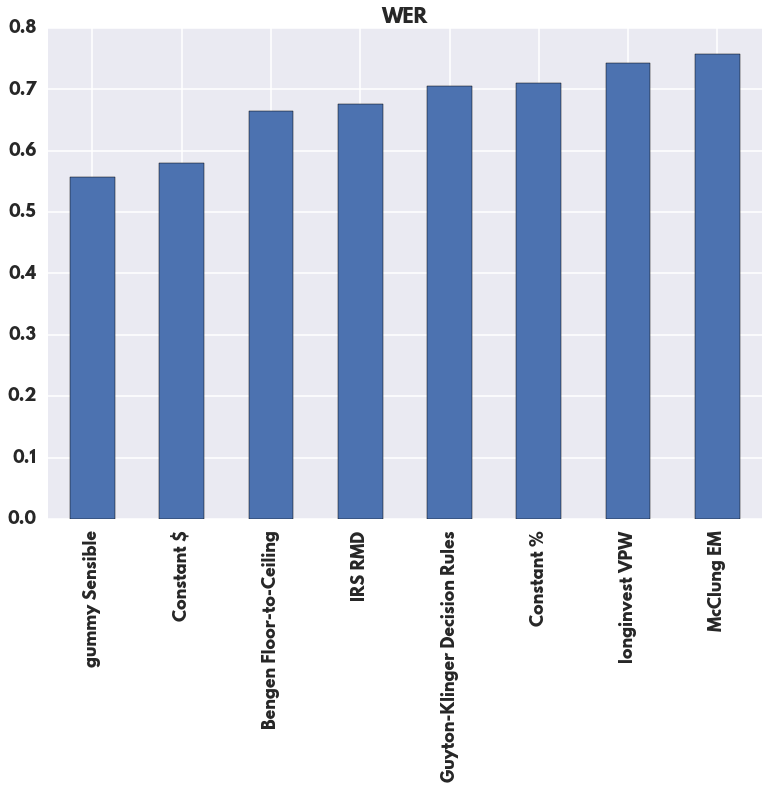

In [25]:
series = pandas.Series(wers)

series.sort_values(inplace=True)
series.plot(kind='bar', title='WER')
#print(series)

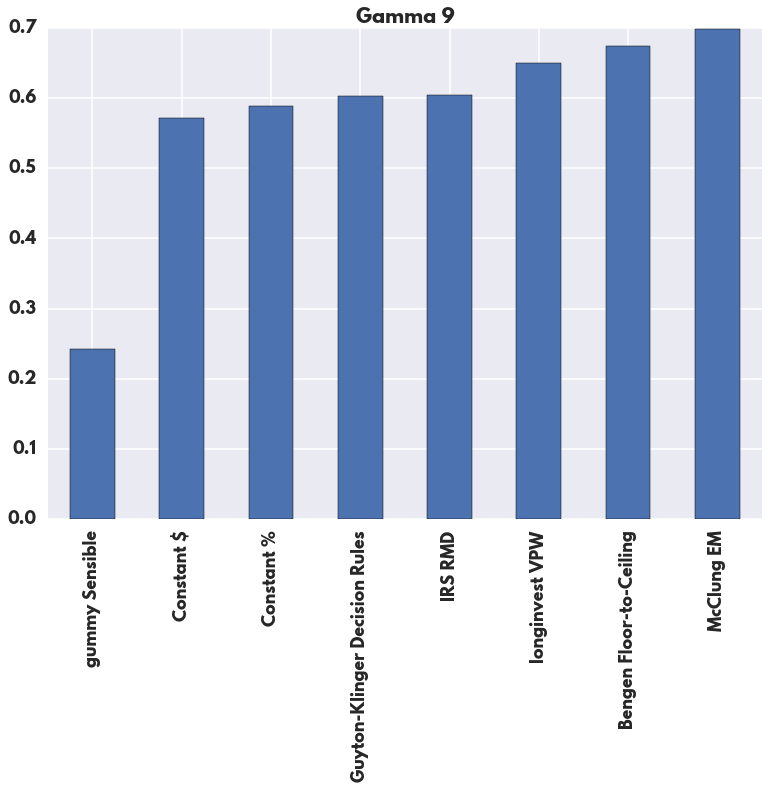

In [26]:
series = pandas.Series(hreffs)

series.sort_values(inplace=True)
series.plot(kind='bar', title='HREFF-%s' % HREFF_FLOOR)
#print(series)

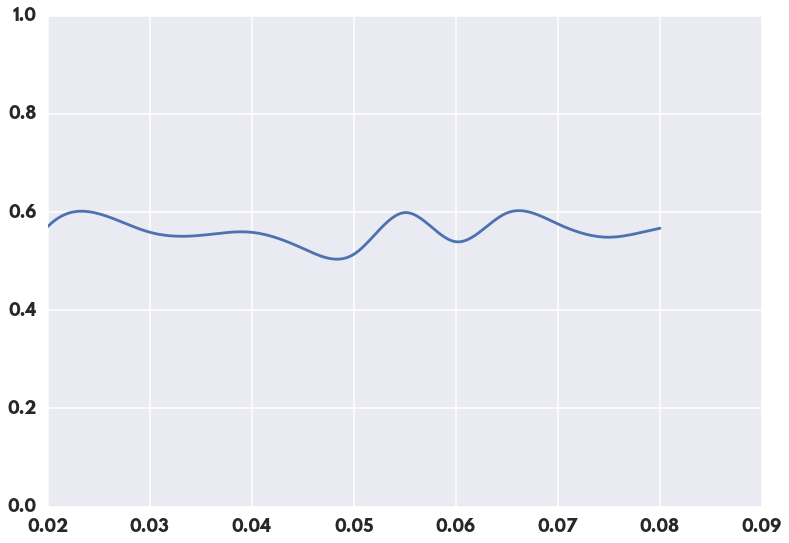

In [27]:
from scipy.interpolate import spline
import numpy as np

#canvas = plt.figure()

for equity in [0]:
    w = []
    r = []
    for rate in range(20, 81, 5):
        rate = D(rate) / 1000
        case = montecarlo.conservative[equity]

        wers = []
        for i in range(100):
            wers.append(run_one(case, withdrawal.ConstantWithdrawals))
        my_wer = average([w[0] for w in wers])
        w.append(my_wer)
        r.append(rate)

    x_smooth = np.linspace(float(min(r)), float(max(r)), 200)
    y_smooth = spline(r, w, x_smooth)

    fig, ax1 = plt.subplots()
    ax1.set_ylim((0,1))
    plt.plot(x_smooth, y_smooth)